# ДЗ:

сдаем ноутбук, где будет продолжение ноутбука на уроке, но включая создание БД где хотите (SQLITE, MySQL, PostgreSQL), создание таблиц с первичными и внешними ключами, включая наполнение данными, и плюс приложить в графическом виде схему базы данных.

## Подготовка csv для базы данных

In [1]:
from google.colab import drive
drive.mount('./drive')

Mounted at ./drive


In [2]:
import warnings
warnings.filterwarnings("ignore")
import re
from re import sub, search, findall
import pandas  as pd
from datetime import datetime
import numpy as np
import glob
import os

In [3]:
def epi_dates_preparation(strng):
    data_1 =  sub(r'(0?[1-9]|[12]\d|30|31)[.](0?[1-9]|1[0-2])[.](\d{4})',
                     '\\1-\\2-\\3', strng)
    return sub(r'(0?[1-9]|[12]\d|30|31)[.](0?[1-9]|1[0-2])[.](\d{2})',
                  '\\1-\\2-20\\3', data_1)

Примитивный, но работоспособный вариант определения пола: удаляем всё, что есть в эпикризе после 1 упоминания слова "диагноз" и ищем "вна", а у мужчин - "вич"

In [4]:
def read_txt(ff):
  with open(ff, encoding='utf-8', errors='ignore') as f:
    f = f.read()
    return f

In [5]:
def get_gender(file_):
  file_ = sub('диагноз.*', '', file_)
  if 'вна' in file_:
    return 25
  else:
    return 26


Убираем "лишнеее".
Подходы: фичи или мусор?

In [6]:
def remover(file_):
  file_ = ''.join(file_.split()).lower()
  stop_element = [',',':', '/t', 'менее']
  for elem in stop_element:
    if elem == ',':
      file_ = sub(elem, '.', file_)
    else:
      file_ = sub(elem, '', file_)
  return(file_)

```

def preparator(path):
	def inner_preparator(fun):
		def wrapper(*args, **kwargs):
			txt2 = epi_dates_preparation(remover(read_txt(path)))
			return fun(txt2)
		return wrapper
	return inner_preparator

```

Собираем все файлы

In [7]:
lst_of_txts = list(glob.glob(os.path.join('/content/drive/MyDrive/Data/rwd_raw/rwd_raw', '*.txt')))
lst_of_txts

['/content/drive/MyDrive/Data/rwd_raw/rwd_raw/file (1085).txt',
 '/content/drive/MyDrive/Data/rwd_raw/rwd_raw/file (1094).txt',
 '/content/drive/MyDrive/Data/rwd_raw/rwd_raw/file (1093).txt',
 '/content/drive/MyDrive/Data/rwd_raw/rwd_raw/file (1090).txt',
 '/content/drive/MyDrive/Data/rwd_raw/rwd_raw/file (1091).txt',
 '/content/drive/MyDrive/Data/rwd_raw/rwd_raw/file (109).txt',
 '/content/drive/MyDrive/Data/rwd_raw/rwd_raw/file (1088).txt',
 '/content/drive/MyDrive/Data/rwd_raw/rwd_raw/file (1087).txt',
 '/content/drive/MyDrive/Data/rwd_raw/rwd_raw/file (1084).txt',
 '/content/drive/MyDrive/Data/rwd_raw/rwd_raw/file (1086).txt',
 '/content/drive/MyDrive/Data/rwd_raw/rwd_raw/file (107).txt',
 '/content/drive/MyDrive/Data/rwd_raw/rwd_raw/file (1103).txt',
 '/content/drive/MyDrive/Data/rwd_raw/rwd_raw/file (1102).txt',
 '/content/drive/MyDrive/Data/rwd_raw/rwd_raw/file (1100).txt',
 '/content/drive/MyDrive/Data/rwd_raw/rwd_raw/file (1098).txt',
 '/content/drive/MyDrive/Data/rwd_raw/rwd_

In [8]:
len(lst_of_txts)

34

*Функциональный подход*

In [9]:
patient_ids = list(map(lambda file_: int(search(r'\d+', file_)[0]), lst_of_txts))
list_of_epi = list(map(lambda file_: epi_dates_preparation(remover(read_txt(file_))) , lst_of_txts))
gender_list = list(map(lambda file_: get_gender(epi_dates_preparation(remover(read_txt(file_)))) , lst_of_txts))

In [10]:
gender_list

[26,
 25,
 25,
 26,
 25,
 25,
 25,
 26,
 25,
 25,
 25,
 25,
 25,
 25,
 26,
 26,
 26,
 25,
 26,
 26,
 25,
 25,
 26,
 25,
 26,
 26,
 26,
 25,
 25,
 25,
 25,
 25,
 25,
 25]

### Начнём с таблицы `person`

In [11]:
def prepare_person_table(
    gender_list,
    list_of_epi,
    patient_ids,
    hospital_days = [],
    date_of_birth = []
  ):
  for file_ in list_of_epi:
    admission = findall('\d{2}-\d{2}-\d{4}', file_)[1]
    discharge = findall('\d{2}-\d{2}-\d{4}', file_)[-1]
    hospital_days.append(
        datetime.strptime(discharge, '%d-%m-%Y').date() -
        datetime.strptime(admission, '%d-%m-%Y').date())
    date_of_birth.append(findall('\d{2}-\d{2}-\d{4}', file_)[0])
  data_dct = {'person_id ': patient_ids, 'date_of_birth': date_of_birth,'sex_concept_id ': gender_list, 'hospital_days':hospital_days}
  df = pd.DataFrame(data_dct)
  df = df.replace(r'', np.nan, regex=True)
  df['hospital_days'] = df['hospital_days'].dt.days.astype('int16')
  df['date_of_birth'] = pd.to_datetime(df.date_of_birth, format='%d-%m-%Y')
  return df

In [12]:
patient_table = prepare_person_table(gender_list = gender_list,
                          list_of_epi = list_of_epi,
                          patient_ids = patient_ids)
patient_table

,person_id,date_of_birth,sex_concept_id,hospital_days
0,1085,1955-05-08,26,36
1,1094,1946-06-26,25,10
2,1093,1957-05-25,25,52
3,1090,1973-06-01,26,32
4,1091,1961-09-08,25,12
5,109,1970-08-09,25,16
6,1088,1973-08-26,25,19
7,1087,1982-07-26,26,7
8,1084,1964-07-04,25,19
9,1086,1960-02-09,25,13


In [ ]:
patient_table.to_csv('/content/drive/MyDrive/Data/csv/person.csv', index=False)

### Создание файла для таблицы `measurement`

Для того, чтобы сделать процесс формирования таблицы более программатичным,
создадим словарь где ключ - название анализа, а значение это словарь в котором ключ тип исследования, а значение это идентификатор

In [13]:
measurements_map = {
    'фибриноген': {'гемостазиограмма': 6},
    'креатинин': {'биохимическоеисследованиекрови': 7},
    'лейкоциты': {'общийанализкрови': 8},
    'гемоглобин': {'общийанализкрови': 9},
    'тромбоциты': {'общийанализкрови': 10},
    '.-реактивныйбелок': {'биохимическоеисследованиекрови': 11},
    'соэ': {'общийанализкрови': 12},
    'лимфоциты': {'общийанализкрови': 13}
    ,'прокальцитонин': {'ифаанализ': 27}
}

In [14]:
for measurement_name , sub_dict in measurements_map.items():
    for measurement_type, measurement_concept_id_ in sub_dict.items():
      print(sub_dict, measurement_concept_id_)

{'гемостазиограмма': 6} 6
{'биохимическоеисследованиекрови': 7} 7
{'общийанализкрови': 8} 8
{'общийанализкрови': 9} 9
{'общийанализкрови': 10} 10
{'биохимическоеисследованиекрови': 11} 11
{'общийанализкрови': 12} 12
{'общийанализкрови': 13} 13
{'ифаанализ': 27} 27


In [15]:
def measurements_template(
    list_of_epicrisis,
    patient_ids,
    measurements_map,
    measurement_id = [],
    measurement_date  = [],
    measurement_concept_id = [],
    patient_id = [],
    value = []
    ):
  for measurement_name , sub_dict in measurements_map.items():
    for measurement_type, concept_id in sub_dict.items():
        for file_, patient_id_ in zip(list_of_epicrisis, patient_ids):
            pattern0 = ''.join(['r(\d{2}-\d{2}-\d{4})(', measurement_type, ')'])
            file_ = sub(pattern0, r'\2\1', file_)
            pattern1 = ''.join(['(?<=', measurement_type, ')', '(\d{2}-\d{2}-\d{4}|)'])
            for date in findall(pattern1, file_):
              measurement_date .append(date)
              patient_id.append(patient_id_)
              measurement_concept_id.append(concept_id)
            pattern2 = ''.join(['(', measurement_type, ')', '(\d{2}-\d{2}-\d{4}|)'])
            file_1 = sub(pattern2, r'\2\1', file_)
            pattern3 = ''.join(['(', measurement_type, '.*?)', '(?=\d{2}-\d{2}-\d{4})'])
            for value_ in findall(pattern3, file_1):
              value_ = sub(''.join(['(.*)(', measurement_name, ')', '(\d.\d*)']), r'\3\2\1', value_)
              value_ = sub(''.join(['(', measurement_name, '|', measurement_type, ').*']) , '', value_)
              value_ = re.sub('[^0-9.]|х10|x10', '', value_)

              if value_:
                  value.append(value_)
              else:
                  value.append('NA')

  data_dct = {'measurement_id': measurement_id, 'measurement_concept_id': measurement_concept_id,
                      'measurement_date': measurement_date ,'value': value, 'person_id': patient_id}
  df = pd.DataFrame.from_dict(data_dct, orient='index')

  df = df.transpose()
  df['measurement_id'] = df.index
  df = df[df.measurement_date != '']
  df = df[df.value != 'NA']
  df['measurement_date'] = pd.to_datetime(df.measurement_date, format='%d-%m-%Y')

  return df

In [16]:
patient_ids = list(map(lambda file_: int(search(r'\d+', file_)[0]), lst_of_txts))
list_of_epi = list(map(lambda file_: epi_dates_preparation(remover(read_txt(file_))) , lst_of_txts))
measurement_data = measurements_template(list_of_epicrisis = list_of_epi, patient_ids = patient_ids, measurements_map = measurements_map)
measurement_data

,measurement_id,measurement_concept_id,measurement_date,value,person_id
1,1,6,2020-12-17,13,1085
2,2,6,2020-12-20,6.9,1085
3,3,6,2020-12-26,3.3,1085
5,5,6,2021-01-15,7.91,1085
6,6,6,2021-01-19,5.98,1085
...,...,...,...,...,...
1490,1490,27,2020-12-14,None,1068
1491,1491,27,2020-12-16,None,1068
1492,1492,27,2020-12-17,None,1067
1493,1493,27,2020-12-17,None,1067


In [20]:
measurement_data['value'].isnull().sum()

10

In [22]:
measurement_data.tail(11)

,measurement_id,measurement_concept_id,measurement_date,value,person_id
1483,1483,27,2020-12-16,0.01,1070
1485,1485,27,2021-01-06,None,1070
1486,1486,27,2021-01-14,None,1070
1487,1487,27,2020-12-14,None,1069
1488,1488,27,2020-12-16,None,1069
1489,1489,27,2020-12-21,None,1069
1490,1490,27,2020-12-14,None,1068
1491,1491,27,2020-12-16,None,1068
1492,1492,27,2020-12-17,None,1067
1493,1493,27,2020-12-17,None,1067


Заменяем None на 0:

In [24]:
measurement_data = measurement_data.fillna(0)
measurement_data

,measurement_id,measurement_concept_id,measurement_date,value,person_id
1,1,6,2020-12-17,13,1085
2,2,6,2020-12-20,6.9,1085
3,3,6,2020-12-26,3.3,1085
5,5,6,2021-01-15,7.91,1085
6,6,6,2021-01-19,5.98,1085
...,...,...,...,...,...
1490,1490,27,2020-12-14,0,1068
1491,1491,27,2020-12-16,0,1068
1492,1492,27,2020-12-17,0,1067
1493,1493,27,2020-12-17,0,1067


In [25]:
measurement_data.to_csv('/content/drive/MyDrive/Data/csv/measurements.csv', index=False)

Учитывая, что ошибки в написании препаратов это нередкость и препараты могут иметь разные коммерческие названия, тогда наша задача сделать "маппинг" этих препаратов к ингредиенту.

In [ ]:
treatment_map = {
    'лизиноприл':{'л.з.....ил|лизитар|лизинеоприл|лизоретик|диротон': 20},
    'цефтриаксон':{'три.....ф|цефт.....он|цефтриакосн': 16},
    "бисопролол":{"б.с.пр..ол|бисопралдол|бикард|конкор": 21},
     "аспирин": {"аспкиард|кардиомагнил|ас....рд": 22},
     "дексаметазон": {"декс.......н|дексаетазон": 15},
     "азитромицин": {"азит.......": 18},
    'гепарин': {'гепарин': 19 }
}

In [ ]:
def treatment_detection(
    list_of_epicrisis,
    patient_ids,
    treatment_map,
    drug_id = [],
    drug_date  = [],
    drug_concept_id = [],
    patient_id = []
    ):
  for drug_name , sub_dct in treatment_map.items():
    for variations, drugs_id in sub_dct.items():
      for file_, patient_id_ in zip(list_of_epicrisis, patient_ids):
        file_ = sub(variations, drug_name, file_)
        if drug_name in  file_:
          drug_date.append(findall('\d{2}-\d{2}-\d{4}', file_)[-1])
          drug_concept_id.append(drugs_id)
          patient_id.append(patient_id_)
  data_dct = {'drug_id': drug_id, 'drug_concept_id': drug_concept_id,
                      'drug_date': drug_date, 'person_id': patient_id}
  df = pd.DataFrame.from_dict(data_dct, orient='index')
  df = df.transpose()
  df['drug_id'] = df.index + 1
  df['drug_date'] = pd.to_datetime(df.drug_date, format='%d-%m-%Y')
  return(df)

In [ ]:
drug_data = treatment_detection(
    list_of_epicrisis = list_of_epi,
    patient_ids = patient_ids,
     treatment_map = treatment_map
)

In [ ]:
drug_data

,drug_id,drug_concept_id,drug_date,person_id
0,1,20,2021-01-14,1097
1,2,20,2021-01-12,1079
2,3,20,2020-12-24,1073
3,4,16,2021-01-18,1090
4,5,16,2021-01-05,1088
...,...,...,...,...
79,80,19,2020-12-24,1073
80,81,19,2020-12-31,1071
81,82,19,2021-02-01,1070
82,83,19,2020-12-30,1068


In [ ]:
drug_data.to_csv('/content/drive/MyDrive/Data/csv/drugs.csv', index=False)

Сейчас поработаем с доменом "Заболевания"

In [ ]:
condition_procedures_map = {
    1:	{'Внегоспитальная пневмония': 'пне...ния|внегоспитальная|внебольничная'},
    2:	{'Ишемическая болезнь сердца': 'ссн|ибс|атеросклеротический|кардиосклероз|фп|фибрил....' },
    3:	{'Сахарный диабет': 'д.абет|сдтип|сд2|сд1|сах.....'},
    4:	{'Коронавирусная инфекция': 'covid19|коронавирусная|b34|sarscov2'},
    5:	{'Артериальная гипертензия': 'аг\d|агi|артериальнаягипер '},
    23:	{'Рентгелологическое исследование грудной клетки': 'rgогк|ргогк'},
    24:	{'Электрокардиография': 'экг|электрокардио'}
}

In [ ]:
def condition_detection(
    list_of_epicrisis,
    patient_ids,
    condition_map,
    condition_id = [],
    condition_date  = [],
    condition_concept_id = [],
    patient_id = []
    ):
  for concept_id , sub_dct in condition_map.items():
    if concept_id < 6:
      for condition, variations in  sub_dct.items():
        for file_, patient_id_ in zip(list_of_epicrisis, patient_ids):
          file_ = sub(variations, condition, file_)
          if condition in  file_:
            condition_date.append(findall('\d{2}-\d{2}-\d{4}', file_)[-1])
            condition_concept_id.append(concept_id)
            patient_id.append(patient_id_)
  data_dct = {'condition_id': condition_id, 'condition_concept_id': condition_concept_id,
                      'condition_date': condition_date, 'person_id': patient_id}
  df = pd.DataFrame.from_dict(data_dct, orient='index')
  df = df.transpose()
  df['condition_id'] = df.index + 1
  df['condition_date'] = pd.to_datetime(df.condition_date, format='%d-%m-%Y')
  return(df)

In [ ]:
condition_data = condition_detection(
    list_of_epicrisis = list_of_epi,
    patient_ids = patient_ids,
    condition_map = condition_procedures_map
)
condition_data

,condition_id,condition_concept_id,condition_date,person_id
0,1,1,2021-01-21,1085
1,2,1,2020-12-28,1094
2,3,1,2021-02-08,1093
3,4,1,2021-01-18,1090
4,5,1,2020-12-30,1091
...,...,...,...,...
80,81,5,2020-12-21,1083
81,82,5,2020-12-24,1080
82,83,5,2021-01-12,1079
83,84,5,2020-12-30,1075


In [ ]:
condition_data.to_csv('/content/drive/MyDrive/Data/csv/conditions.csv', index=False)

In [ ]:
def procedures_detection(
    list_of_epicrisis,
    patient_ids,
    procedure_map,
    procedure_id = [],
    procedure_date  = [],
    procedure_concept_id = [],
    patient_id = []
    ):
  for concept_id , sub_dct in procedure_map.items():
    if concept_id > 6:
      for procedure, variations in  sub_dct.items():
        for file_, patient_id_ in zip(list_of_epicrisis, patient_ids):
          file_ = sub(variations, procedure, file_)
          if procedure in  file_:
            procedure_date.append(findall('\d{2}-\d{2}-\d{4}', file_)[-1])
            procedure_concept_id.append(concept_id)
            patient_id.append(patient_id_)
  data_dct = {'procedure_id': procedure_id, 'procedure_concept_id': procedure_concept_id,
                      'procedure_date': procedure_date, 'person_id': patient_id}
  df = pd.DataFrame.from_dict(data_dct, orient='index')
  df = df.transpose()
  df['procedure_id'] = df.index + 1
  df['procedure_date'] = pd.to_datetime(df.procedure_date, format='%d-%m-%Y')
  return(df)

In [ ]:
procedures_data = procedures_detection(
    list_of_epicrisis = list_of_epi,
    patient_ids = patient_ids,
    procedure_map = condition_procedures_map
)
procedures_data

,procedure_id,procedure_concept_id,procedure_date,person_id
0,1,23,2021-01-27,1074
1,2,24,2021-02-08,1093
2,3,24,2021-02-05,107
3,4,24,2021-01-14,1097
4,5,24,2020-12-21,1083
5,6,24,2021-02-10,108
6,7,24,2020-12-31,1071


In [ ]:
procedures_data.to_csv('/content/drive/MyDrive/Data/csv/procedures.csv', index=False)

Преобразование нужного нам листа в файле База данных.xlsx в файл vocabulary.csv:

In [ ]:
voc = pd.read_excel('/content/drive/MyDrive/Data/База данных.xlsx', sheet_name='Словарь')
voc.to_csv('/content/drive/MyDrive/Data/csv/vocabulary.csv', index=False)
voc

,concept_id,concept_name,domain,code
0,1,Внегоспитальная пневмония,Заболевание,J18
1,2,Ишемическая болезнь сердца,Заболевание,I25
2,3,Сахарный диабет,Заболевание,E11
3,4,Коронавирусная инфекция,Заболевание,U07
4,5,Артериальная гипертензия,Заболевание,I10
5,6,Фибриноген,Измерение,892813
6,7,Креатинин,Измерение,892814
7,8,Лейкоциты,Измерение,892815
8,9,Гемоглобин,Измерение,892816
9,10,Тромбоциты,Измерение,892817


In [ ]:
vocabulary = pd.read_csv('/content/drive/MyDrive/Data/csv/vocabulary.csv')
vocabulary

,concept_id,concept_name,domain,code
0,1,Внегоспитальная пневмония,Заболевание,J18
1,2,Ишемическая болезнь сердца,Заболевание,I25
2,3,Сахарный диабет,Заболевание,E11
3,4,Коронавирусная инфекция,Заболевание,U07
4,5,Артериальная гипертензия,Заболевание,I10
5,6,Фибриноген,Измерение,892813
6,7,Креатинин,Измерение,892814
7,8,Лейкоциты,Измерение,892815
8,9,Гемоглобин,Измерение,892816
9,10,Тромбоциты,Измерение,892817



Моя база данных MySQL с наполнением:
```

DROP DATABASE IF EXISTS gb_rwd;
CREATE DATABASE gb_rwd;
USE gb_rwd;

CREATE TABLE gb_rwd.vocabulary (
  concept_id INT UNSIGNED NOT NULL AUTO_INCREMENT UNIQUE PRIMARY KEY,
  concept_name VARCHAR(255),
  domain VARCHAR(150),
  code VARCHAR(150)
);

LOAD DATA INFILE 'C:/ProgramData/MySQL/MySQL Server 8.0/csv/vocabulary.csv'
INTO TABLE gb_rwd.vocabulary
FIELDS TERMINATED BY ','
ENCLOSED BY '"'
LINES TERMINATED BY '\n'
IGNORE 1 LINES;

CREATE TABLE gb_rwd.person (
  person_id INT UNSIGNED NOT NULL AUTO_INCREMENT UNIQUE PRIMARY KEY,
  date_of_birth DATE,
  sex_concept_id INT UNSIGNED,
  hospital_days INT,
  FOREIGN KEY (sex_concept_id) REFERENCES vocabulary(concept_id) ON UPDATE CASCADE ON DELETE CASCADE
);

LOAD DATA INFILE 'C:/ProgramData/MySQL/MySQL Server 8.0/csv/person.csv'
INTO TABLE gb_rwd.person
FIELDS TERMINATED BY ','
ENCLOSED BY '"'
LINES TERMINATED BY '\n'
IGNORE 1 LINES;


CREATE TABLE gb_rwd.measurement (
  measurement_id INT UNSIGNED NOT NULL AUTO_INCREMENT UNIQUE PRIMARY KEY,
  measurement_concept_id INT UNSIGNED,
  measurement_date DATE,
  value FLOAT,
  person_id INT UNSIGNED,
  FOREIGN KEY (person_id) REFERENCES person(person_id) ON UPDATE CASCADE ON DELETE CASCADE,
  FOREIGN KEY (measurement_concept_id) REFERENCES vocabulary(concept_id) ON UPDATE CASCADE ON DELETE CASCADE
);

LOAD DATA INFILE 'C:/ProgramData/MySQL/MySQL Server 8.0/csv/measurements.csv'
INTO TABLE gb_rwd.measurement
FIELDS TERMINATED BY ','
ENCLOSED BY '"'
LINES TERMINATED BY '\n'
IGNORE 1 LINES;

CREATE TABLE gb_rwd.condition (
  condition_id INT UNSIGNED NOT NULL AUTO_INCREMENT UNIQUE PRIMARY KEY,
  condition_concept_id INT UNSIGNED,
  condition_date DATE,
  person_id INT UNSIGNED,
  FOREIGN KEY (person_id) REFERENCES person(person_id) ON UPDATE CASCADE ON DELETE CASCADE,
  FOREIGN KEY (condition_concept_id) REFERENCES vocabulary(concept_id) ON UPDATE CASCADE ON DELETE CASCADE
);

LOAD DATA INFILE 'C:/ProgramData/MySQL/MySQL Server 8.0/csv/conditions.csv'
INTO TABLE gb_rwd.condition
FIELDS TERMINATED BY ','
ENCLOSED BY '"'
LINES TERMINATED BY '\n'
IGNORE 1 LINES;

CREATE TABLE gb_rwd.drug (
  drug_id INT UNSIGNED NOT NULL AUTO_INCREMENT UNIQUE PRIMARY KEY,
  drug_concept_id INT UNSIGNED,
  drug_date DATE,
  person_id INT UNSIGNED,
  FOREIGN KEY (person_id) REFERENCES person(person_id) ON UPDATE CASCADE ON DELETE CASCADE,
  FOREIGN KEY (drug_concept_id) REFERENCES vocabulary(concept_id) ON UPDATE CASCADE ON DELETE CASCADE
);

LOAD DATA INFILE 'C:/ProgramData/MySQL/MySQL Server 8.0/csv/drugs.csv'
INTO TABLE gb_rwd.drug
FIELDS TERMINATED BY ','
ENCLOSED BY '"'
LINES TERMINATED BY '\n'
IGNORE 1 LINES;

CREATE TABLE gb_rwd.procedure (
  procedure_id INT UNSIGNED NOT NULL AUTO_INCREMENT UNIQUE PRIMARY KEY,
  procedure_concept_id INT UNSIGNED,
  procedure_date DATE,
  person_id INT UNSIGNED,
  FOREIGN KEY (person_id) REFERENCES person(person_id) ON UPDATE CASCADE ON DELETE CASCADE,
  FOREIGN KEY (procedure_concept_id) REFERENCES vocabulary(concept_id) ON UPDATE CASCADE ON DELETE CASCADE
);

LOAD DATA INFILE 'C:/ProgramData/MySQL/MySQL Server 8.0/csv/procedures.csv'
INTO TABLE gb_rwd.procedure
FIELDS TERMINATED BY ','
ENCLOSED BY '"'
LINES TERMINATED BY '\n'
IGNORE 1 LINES;



```



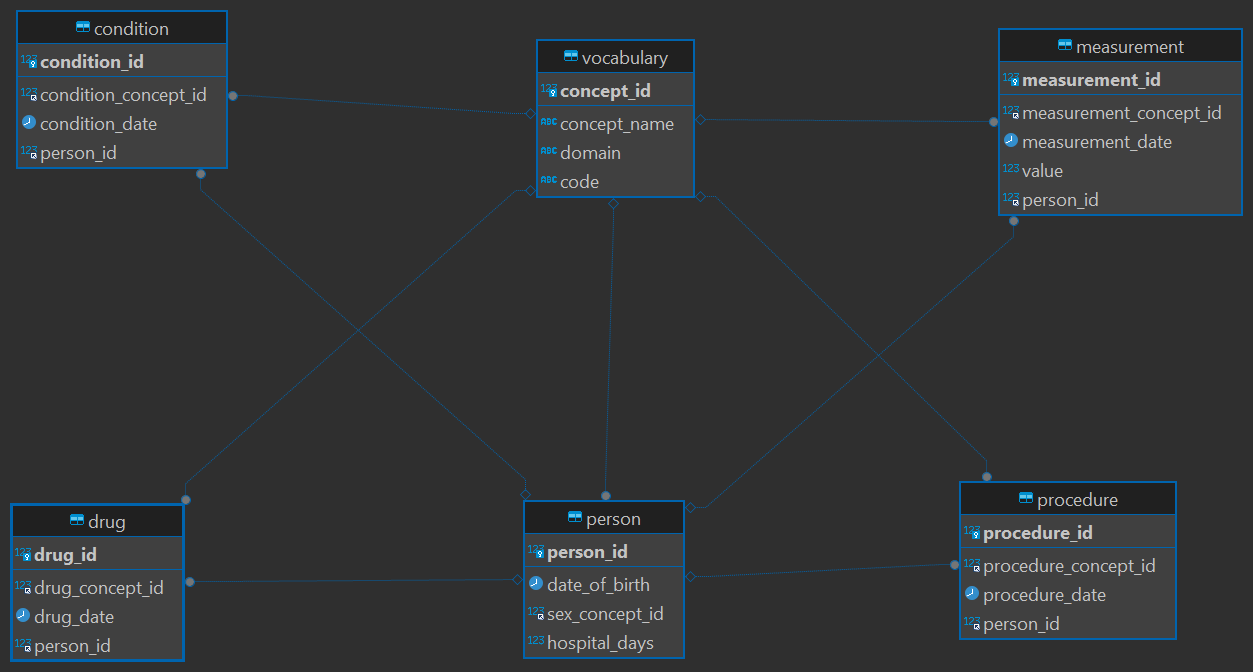